In [1]:
from util import load_pickle
from config import MIMIC_NOTES_PICKLE_SHUFFLED, RXNAV_PATH, MEDDRA_CSV_PATH
import pandas as pd
from util import load_pickle
from a4_rxnorm import RxNav


In [6]:
# from config import MIMIC_PRESCRIPTION_PATH
# prescriptions = pd.read_csv(MIMIC_PRESCRIPTION_PATH)

In [7]:
# prescriptions

In [8]:
# all_mimic_drugs = prescriptions['DRUG_NAME_GENERIC']

In [2]:
groupedby = load_pickle("groupedby.pickle")

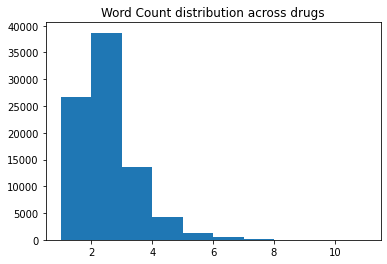

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

all_drugs = {drug for obj in groupedby.values() for pred in obj.values() for drug in pred['DRUG']}
all_drugs_len = [len(drug.split()) for drug in all_drugs]
plt.title("Word Count distribution across drugs")
plt.hist(all_drugs_len,bins=10)
plt.show()

In [4]:
from itertools import groupby
sorted_drugs = list(sorted(all_drugs,key=lambda drug: len(drug.split())))
bylens_group = {length: list(els) for length, els in groupby(sorted_drugs,key=lambda drug: len(drug.split()))}

In [12]:
# df = pd.read_pickle(MIMIC_NOTES_PICKLE_SHUFFLED)

In [5]:
rxnav : RxNav = load_pickle(RXNAV_PATH)
rx_df, drug_targets, rx_str_id, rx_id_str, rx_resolve = rxnav

In [6]:
meddra_csv = pd.read_csv(MEDDRA_CSV_PATH)

In [7]:
all_meddra_drugs = set(meddra_csv['drug_name'].unique())

In [10]:
from Levenshtein import ratio
import re
from collections import Counter
from string import punctuation
from itertools import takewhile

punc_patt = re.compile(rf'[{punctuation}]')
anti_word_patt = re.compile(rf'\W')

def find_with_exceptions(drug_name):
    if drug_name.startswith("ancef"):
        return (1,"cefazolin")
    return None

def find_closest_drug(drugname):
    first_word = drugname.split()[0]
    scores = ((ratio(first_word.lower(),target_drug.lower()),target_drug) for target_drug in all_meddra_drugs)
    return max(scores,key=lambda el : el[0])

def find_closest_drug_rx(drugname):
    first_word = drugname.split()[0]
    scores = ((ratio(first_word.lower().split()[0],target_drug.lower().split()[0]),target_drug) for target_drug in drug_targets)
    return max(scores,key=lambda el : (el[0],-len(el[1]))) # maximize ratio, then minimize length


def extract_drug_sider(drug_name):
    candidates = [find_closest_drug(el) for el in anti_word_patt.sub(' ',drug_name).split() if len(el) > 3]   
    return [term for score, term in candidates if score > 0.8]

def extract_drug_rx(drug_name):
    all_drugs = punc_patt.split(drug_name)
    candidates = [find_rxnav(el) for drug_name in all_drugs for el in anti_word_patt.sub(' ',drug_name).split() if len(el) > 3]
    return candidates

def find_rxnav(term):
    likely_can = [(target,rx_str_id[target]) for target in drug_targets if target.lower().startswith(term.lower())]
    return min(likely_can,key=lambda target: len(target[0]),default=None)

def find_rxnav_all(term):
    likely_can = [(target,rx_str_id[target]) for target in drug_targets if target.lower().startswith(term.lower())]
    return sorted(likely_can,key=lambda target: len(target[0]))

def find_sider_from_rxnav_with_id(rx_id):
    if rx_id not in rx_resolve:
        return None
    sider_possible_set = {term.split()[0].lower() for _,term in rx_resolve[rx_id]}
    scores = [find_closest_drug(sider_possible) for sider_possible in sider_possible_set]
    return max(scores,key=lambda el: el[0],default=None)

def find_sider_from_rxnav(term):
    rx_id_result = find_rxnav(term)
    if rx_id_result is None:
        return None    
    _ , rx_id = rx_id_result
    return find_sider_from_rxnav_with_id(rx_id)

def find_closest_sider_from_rxnav(term):
    score, term = find_closest_drug_rx(term)
    if score < 0.8:
        return None
    rx_id = rx_str_id[term]
    return find_sider_from_rxnav_with_id(rx_id)


def match_drug(drug_name):
    '''This is the function to use when matching drugs'''
    # first check if it's exception
    fns = [find_with_exceptions, find_closest_drug, find_sider_from_rxnav,find_closest_sider_from_rxnav]
    for fn in fns:
        result = fn(drug_name)
        if result is not None:
            score, _ = result
            if score > 0.8:
                return result


In [22]:
find_rxnav("tylenol")

('Tylenol', '202433')

In [11]:
match_drug('tylenol')

TypeError: cannot unpack non-iterable NoneType object

In [55]:
find_with_exceptions("ancef")

'cefazolin'

In [51]:
find_rxnav_all('ancef')

[('Ancef', '203483'),
 ('Ancef 1g Powder for Injection', '1665078'),
 ('Ancef 500mg Powder for Injection', '1665081'),
 ('Ancef 10g Bulk Powder for Injection', '1665079'),
 ('Ancef, 500 mg/50 mL intravenous solution', '1665082'),
 ('Ancef, 1 g injectable powder for injection', '1665078'),
 ('Ancef, 5 g injectable powder for injection', '1665079'),
 ('Ancef, 10 g injectable powder for injection', '1665079'),
 ('Ancef 1g/50ml Premixed Solution for Injection', '1665077'),
 ('Ancef, 500 mg injectable powder for injection', '1665081'),
 ('Ancef 500mg/50ml Premixed Solution for Injection', '1665082'),
 ('Ancef, 1 g/50 mL-iso-osmotic dextrose intravenous solution', '1994655')]

In [53]:
find_closest_drug('cefazolin')

(1.0, 'cefazolin')

In [47]:
find_closest_sider_from_rxnav('ancef')

In [39]:
find_sider_from_rxnav("dilaudid")

(1.0, 'hydromorphone')

In [38]:
find_sider_from_rxnav("vesicare")

(1.0, 'solifenacin')

In [23]:
find_rxnav('acetaminophen')

('Acetaminophen', '161')

In [32]:
# sorted(rx_resolve['202433'],key=lambda tup: len(tup[1]))

    

In [33]:
find_sider_from_rxnav('tylenol')

(1.0, 'acetaminophen')

In [34]:
find_sider_from_rxnav('zosyn')

(1.0, 'piperacillin')

In [17]:
max([len(drug.split()) for drug in all_meddra_drugs])

1

In [18]:
Counter(bylens_group[2]).most_common(10)

[('amlodipine aldactone', 1),
 ('dexamethasone gtt', 1),
 ('high bs', 1),
 ('dobutamine svo2', 1),
 ('hydrogel dsg', 1),
 ('valproate acid', 1),
 ('warfarin l', 1),
 ('guaiac stool', 1),
 ('cepacol lozenge', 1),
 ('- albuterol', 1)]

In [19]:
extract_drug_rx('nacardipine labetolol')

TypeError: <lambda>() missing 1 required positional argument: 'id'

In [ ]:
nodrug = dict()
has_rx = dict()
has_sider = dict()

for i,drug in enumerate(all_drugs):
    splitted_drugs = punc_patt.split(drug)
    all_valid_drugs = [real_drug for pot_drug in splitted_drugs for real_drug in clean_drug(pot_drug)]
    if len(all_valid_drugs) > 0:
        has_sider[i] = all_valid_drugs
        continue
    all_rxnav_drugs = 
    # first check if in SIDER
    

SyntaxError: invalid syntax (4120019531.py, line 11)